In [249]:
import numpy as np
import numpy_financial as npf
import pandas as pd 
import matplotlib.pyplot as plt 

# Dimensionierung & Kosten
anlagenleistung_kwp = 10
investition_pro_kwp = 2500.0 # CHF/kWp
grundbeitrag_eiv = 1400      # CHF (Kanton Luzern ab 2015) Uri: 1000 Nidwalden: 3600 Obwalden: 3600
leistungsbeitrag_eiv_pro_kwp = 500 # CHF/kWp (Kanton Luzern ab 2015) Uri: 250 Nid-Obwalden:0

# Produktion & Verbrauch
spezifischer_ertrag_kwh_pro_kwp = 900.0 # kWh/kWp/Jahr
eigenverbrauchsquote = 0.70         # Anteil des selbst genutzten Stroms (z.B. 0.4 für 40%)
degradation_pa = 0.005               # Jährlicher Leistungsverlust (z.B. 0.004 für 0.4%)

# Preise & Tarife
strompreis_bezug_start = 0.25      # CHF/kWh (aktueller Preis für bezogenen Strom) Luzern: 25rp. Uri: 30rp Nidwalden: 23rp Obwalden: 27rp.
einspeiseverguetung_start = 0.06 # CHF/kWh (aktueller Tarif für eingespeisten Strom) Luzern: 6rp. Uri: 5rp Nidwalden: 5rp Obwalden: 10rp
strompreisentwicklung_pa = 0.01  # Erwartete jährliche Steigerung des Bezugspreises (z.B. 0.02 für 2%)
# Annahme: Einspeisevergütung bleibt konstant oder folgt einem anderen Trend (hier konstant angenommen)

# Betrieb & Finanzierung
betriebskosten_anteil = 0.01 # Jährliche Betriebskosten als Anteil der Bruttoinvestition (z.B. 0.008 für 0.8%)
diskontsatz = 0.04           # Jährlicher Zinssatz für Abzinsung (Kapitalkosten) (z.B. 0.03 für 3%)
max_jahre = 25               # Maximal betrachteter Zeitraum

# Ökologische Aspekte
co2_faktor_vermeidung_kg_kwh = 0.0547 # kg CO2eq pro ersetzter kWh (Schätzung) 0.0547
lebensdauer_jahre = 25             # Angenommene Lebensdauer für CO2-Gesamtbilanz

In [250]:
# Investition
investition_brutto = anlagenleistung_kwp * investition_pro_kwp
# EIV Berechnung (vereinfacht, ggf. anpassen an aktuelle Pronovo-Regeln)
foerderung_eiv = grundbeitrag_eiv + (anlagenleistung_kwp * leistungsbeitrag_eiv_pro_kwp)
investition_netto = investition_brutto - foerderung_eiv

# Jährliche Betriebskosten
betriebskosten_fix_pa = investition_brutto * betriebskosten_anteil

# Jährliche Berechnungen über die Zeit
jahre = np.arange(1, max_jahre + 1)
produktion_kwh_pro_jahr = np.zeros(max_jahre)
strompreis_bezug_pro_jahr = np.zeros(max_jahre)
einspeiseverguetung_pro_jahr = np.zeros(max_jahre) # Hier konstant angenommen
einsparung_eigenverbrauch_pro_jahr = np.zeros(max_jahre)
einnahme_einspeisung_pro_jahr = np.zeros(max_jahre)
betriebskosten_pro_jahr = np.full(max_jahre, betriebskosten_fix_pa) # Annahme: real konstant
cashflow_nominal_pro_jahr = np.zeros(max_jahre)
cashflow_diskontiert_pro_jahr = np.zeros(max_jahre)

# Initialproduktion im ersten Jahr
produktion_kwh_pro_jahr[0] = anlagenleistung_kwp * spezifischer_ertrag_kwh_pro_kwp
# Strompreis und Vergütung im ersten Jahr
strompreis_bezug_pro_jahr[0] = strompreis_bezug_start
einspeiseverguetung_pro_jahr[0] = einspeiseverguetung_start

In [251]:
# Berechnungen für jedes Jahr
for jahr_index in range(max_jahre):
    jahr = jahr_index + 1

    # Produktion mit Degradation (Degradation wirkt ab Jahr 2)
    if jahr > 1:
        produktion_kwh_pro_jahr[jahr_index] = produktion_kwh_pro_jahr[jahr_index-1] * (1 - degradation_pa)
        strompreis_bezug_pro_jahr[jahr_index] = strompreis_bezug_pro_jahr[jahr_index-1] * (1 + strompreisentwicklung_pa)
        # Annahme: Einspeisevergütung bleibt konstant
        einspeiseverguetung_pro_jahr[jahr_index] = einspeiseverguetung_start
    else: # Für Jahr 1 bereits oben initialisiert
         pass # Produktion und Preise für Jahr 1 sind schon gesetzt


    # Aufteilung Produktion
    aktueller_ertrag = produktion_kwh_pro_jahr[jahr_index]
    eigenverbrauch_kwh = aktueller_ertrag * eigenverbrauchsquote
    einspeisung_kwh = aktueller_ertrag * (1 - eigenverbrauchsquote)

    # Finanzielle Ströme des Jahres
    einsparung_eigenverbrauch = eigenverbrauch_kwh * strompreis_bezug_pro_jahr[jahr_index]
    einnahme_einspeisung = einspeisung_kwh * einspeiseverguetung_pro_jahr[jahr_index]

    # Jährlicher nominaler Cashflow (vor Abzinsung)
    cashflow_nominal = einsparung_eigenverbrauch + einnahme_einspeisung - betriebskosten_pro_jahr[jahr_index]

    # Jährlicher diskontierter Cashflow (Barwert)
    cashflow_diskontiert = cashflow_nominal / ((1 + diskontsatz) ** jahr)

    # Speichern der Jahreswerte
    einsparung_eigenverbrauch_pro_jahr[jahr_index] = einsparung_eigenverbrauch
    einnahme_einspeisung_pro_jahr[jahr_index] = einnahme_einspeisung
    cashflow_nominal_pro_jahr[jahr_index] = cashflow_nominal
    cashflow_diskontiert_pro_jahr[jahr_index] = cashflow_diskontiert

# Kumulierte Cashflows
kum_cashflow_nominal = np.cumsum(cashflow_nominal_pro_jahr)
kum_cashflow_diskontiert = np.cumsum(cashflow_diskontiert_pro_jahr)

# Amortisationszeiten finden
# Einfache Amortisation: Wann übersteigt der kumulierte nominale Cashflow die Nettoinvestition?
try:
    amortisationszeit_einfach_jahre = np.where(kum_cashflow_nominal >= investition_netto)[0][0] + 1
except IndexError:
    amortisationszeit_einfach_jahre = np.inf # Nicht amortisiert innerhalb des Zeitraums

# Diskontierte Amortisation: Wann übersteigt der kumulierte diskontierte Cashflow die Nettoinvestition?
try:
    amortisationszeit_diskontiert_jahre = np.where(kum_cashflow_diskontiert >= investition_netto)[0][0] + 1
except IndexError:
    amortisationszeit_diskontiert_jahre = np.inf # Nicht amortisiert innerhalb des Zeitraums

# Ökologische Berechnung
gesamtertrag_lebensdauer = produktion_kwh_pro_jahr[:lebensdauer_jahre].sum()
co2_einsparung_gesamt_tonnen = (gesamtertrag_lebensdauer * co2_faktor_vermeidung_kg_kwh) / 1000

In [252]:
print("--- Rahmenbedingungen ---")
print(f"Anlagenleistung: {anlagenleistung_kwp:.1f} kWp")
print(f"Bruttoinvestition: {investition_brutto:,.2f} CHF")
print(f"Förderung (EIV, geschätzt): {foerderung_eiv:,.2f} CHF")
print(f"Nettoinvestition: {investition_netto:,.2f} CHF")
print(f"Erwarteter Jahresertrag (Jahr 1): {produktion_kwh_pro_jahr[0]:,.0f} kWh")
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0%}")
print(f"Strompreis Bezug (Start): {strompreis_bezug_start:.2f} CHF/kWh")
print(f"Einspeisevergütung (Start): {einspeiseverguetung_start:.2f} CHF/kWh")
print(f"Annahme Strompreissteigerung: {strompreisentwicklung_pa:.1%}")
print(f"Betriebskosten pro Jahr: {betriebskosten_fix_pa:,.2f} CHF")
print(f"Diskontsatz: {diskontsatz:.1%}")
print(f"Degradation p.a.: {degradation_pa:.1%}")
print("-" * 30)

print("--- Wirtschaftlichkeit ---")
if amortisationszeit_einfach_jahre == np.inf:
    print(f"Einfache Amortisationszeit: > {max_jahre} Jahre")
else:
    # Optional: Genauere Berechnung innerhalb des Jahres
    jahr_vorher = amortisationszeit_einfach_jahre - 1
    restbetrag = investition_netto - (kum_cashflow_nominal[jahr_vorher-1] if jahr_vorher > 0 else 0)
    cashflow_im_amortisationsjahr = cashflow_nominal_pro_jahr[jahr_vorher]
    amortisationszeit_einfach_genau = jahr_vorher + restbetrag / cashflow_im_amortisationsjahr
    print(f"Einfache Amortisationszeit: {amortisationszeit_einfach_jahre} Jahre (genauer: ca. {amortisationszeit_einfach_genau:.1f} Jahre)")


if amortisationszeit_diskontiert_jahre == np.inf:
    print(f"Diskontierte Amortisationszeit: > {max_jahre} Jahre")
else:
     # Optional: Genauere Berechnung innerhalb des Jahres (vereinfacht linear)
    jahr_vorher_d = amortisationszeit_diskontiert_jahre - 1
    restbetrag_d = investition_netto - (kum_cashflow_diskontiert[jahr_vorher_d-1] if jahr_vorher_d > 0 else 0)
    cashflow_im_amortisationsjahr_d = cashflow_diskontiert_pro_jahr[jahr_vorher_d]
    if cashflow_im_amortisationsjahr_d > 0: # Vermeide Division durch Null
      amortisationszeit_diskontiert_genau = jahr_vorher_d + restbetrag_d / cashflow_im_amortisationsjahr_d
      print(f"Diskontierte Amortisationszeit: {amortisationszeit_diskontiert_jahre} Jahre (genauer: ca. {amortisationszeit_diskontiert_genau:.1f} Jahre)")
    else:
      print(f"Diskontierte Amortisationszeit: {amortisationszeit_diskontiert_jahre} Jahre (Cashflow im Jahr = 0, keine genauere Angabe)")



--- Rahmenbedingungen ---
Anlagenleistung: 10.0 kWp
Bruttoinvestition: 25,000.00 CHF
Förderung (EIV, geschätzt): 6,400.00 CHF
Nettoinvestition: 18,600.00 CHF
Erwarteter Jahresertrag (Jahr 1): 9,000 kWh
Eigenverbrauchsquote: 70%
Strompreis Bezug (Start): 0.25 CHF/kWh
Einspeisevergütung (Start): 0.06 CHF/kWh
Annahme Strompreissteigerung: 1.0%
Betriebskosten pro Jahr: 250.00 CHF
Diskontsatz: 4.0%
Degradation p.a.: 0.5%
------------------------------
--- Wirtschaftlichkeit ---
Einfache Amortisationszeit: 13 Jahre (genauer: ca. 12.2 Jahre)
Diskontierte Amortisationszeit: 17 Jahre (genauer: ca. 16.9 Jahre)


In [253]:
# Rendite (z.B. interner Zinsfuss - IRR) kann hier auch berechnet werden
# Erfordert eine Cashflow-Reihe, die die Anfangsinvestition enthält
cashflows_fuer_irr = np.concatenate(([-investition_netto], cashflow_nominal_pro_jahr))
try:
    irr = npf.irr(cashflows_fuer_irr)
    print(f"Interner Zinsfuss (IRR, nominal): {irr:.2%}")
except ValueError:
    print("Interner Zinsfuss (IRR) konnte nicht berechnet werden (möglicherweise keine positive Rendite).")


print("-" * 30)
print("--- Ökologische Perspektive ---")
print(f"Geschätzte CO2-Einsparung über {lebensdauer_jahre} Jahre: {co2_einsparung_gesamt_tonnen:,.1f} Tonnen CO2eq")
print(f"(Basierend auf {co2_faktor_vermeidung_kg_kwh} kg CO2eq pro kWh)")
print("-" * 30)

Interner Zinsfuss (IRR, nominal): 6.68%
------------------------------
--- Ökologische Perspektive ---
Geschätzte CO2-Einsparung über 25 Jahre: 11.6 Tonnen CO2eq
(Basierend auf 0.0547 kg CO2eq pro kWh)
------------------------------


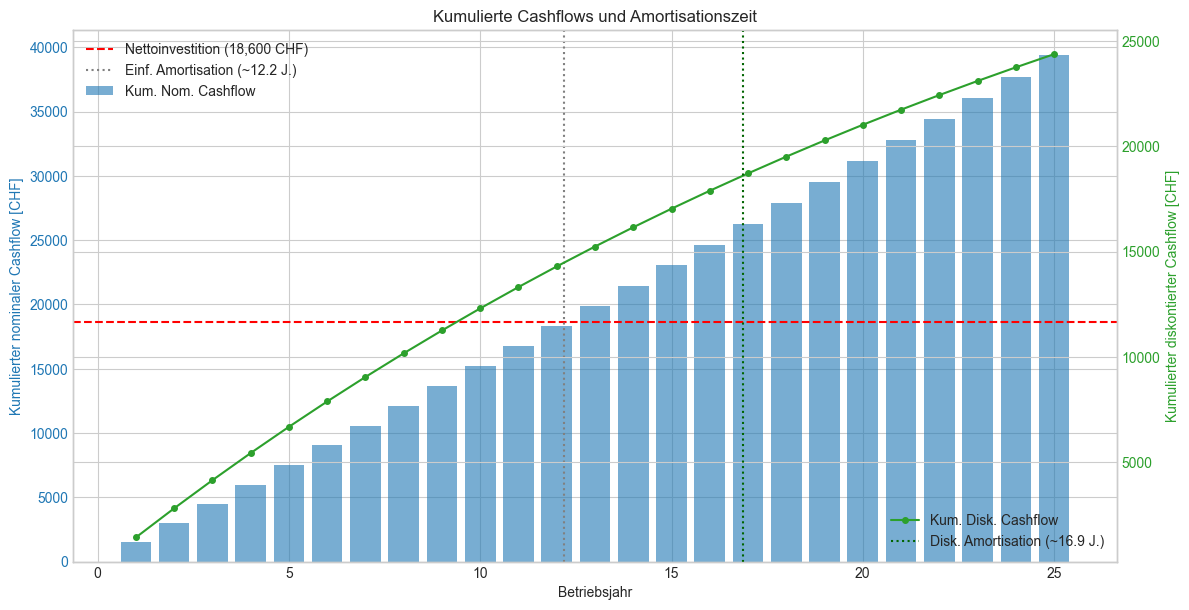

In [254]:
# --- 4. Optionale Visualisierung ---
plt.style.use('seaborn-v0_8-whitegrid') # Schönerer Plot-Stil
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Betriebsjahr')
ax1.set_ylabel('Kumulierter nominaler Cashflow [CHF]', color=color1)
ax1.bar(jahre, kum_cashflow_nominal, color=color1, alpha=0.6, label='Kum. Nom. Cashflow')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(investition_netto, color='red', linestyle='--', label=f'Nettoinvestition ({investition_netto:,.0f} CHF)')
if amortisationszeit_einfach_jahre != np.inf:
    ax1.axvline(amortisationszeit_einfach_genau, color='gray', linestyle=':', label=f'Einf. Amortisation (~{amortisationszeit_einfach_genau:.1f} J.)')


ax2 = ax1.twinx() # Zweite Y-Achse für diskontierten Wert
color2 = 'tab:green'
ax2.set_ylabel('Kumulierter diskontierter Cashflow [CHF]', color=color2)
ax2.plot(jahre, kum_cashflow_diskontiert, color=color2, marker='o', linestyle='-', markersize=4, label='Kum. Disk. Cashflow')
ax2.tick_params(axis='y', labelcolor=color2)
if amortisationszeit_diskontiert_jahre != np.inf and cashflow_im_amortisationsjahr_d > 0:
     ax2.axvline(amortisationszeit_diskontiert_genau, color='darkgreen', linestyle=':', label=f'Disk. Amortisation (~{amortisationszeit_diskontiert_genau:.1f} J.)')


fig.tight_layout()
ax1.set_title('Kumulierte Cashflows und Amortisationszeit')
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
ax1.grid(True)
plt.show()

In [255]:
# Optional: DataFrame für jährliche Übersicht (erfordert pandas)
df_jahreswerte = pd.DataFrame({
     'Jahr': jahre,
     'Produktion [kWh]': produktion_kwh_pro_jahr,
     'Strompreis [CHF/kWh]': strompreis_bezug_pro_jahr,
     'Einspeiseverg. [CHF/kWh]': einspeiseverguetung_pro_jahr,
     'Einsparung EV [CHF]': einsparung_eigenverbrauch_pro_jahr,
     'Einnahme Einspeisung [CHF]': einnahme_einspeisung_pro_jahr,
     'Betriebskosten [CHF]': betriebskosten_pro_jahr,
     'Nominaler Cashflow [CHF]': cashflow_nominal_pro_jahr,
     'Diskontierter Cashflow [CHF]': cashflow_diskontiert_pro_jahr,
     'Kum. Nom. Cashflow [CHF]': kum_cashflow_nominal,
     'Kum. Disk. Cashflow [CHF]': kum_cashflow_diskontiert
 })
print("\n--- Jährliche Übersicht (Auszug) ---")
print(df_jahreswerte.round(2).head())
print("...")
print(df_jahreswerte.round(2).tail())


--- Jährliche Übersicht (Auszug) ---
   Jahr  Produktion [kWh]  Strompreis [CHF/kWh]  Einspeiseverg. [CHF/kWh]  \
0     1           9000.00                  0.25                      0.06   
1     2           8955.00                  0.25                      0.06   
2     3           8910.22                  0.26                      0.06   
3     4           8865.67                  0.26                      0.06   
4     5           8821.35                  0.26                      0.06   

   Einsparung EV [CHF]  Einnahme Einspeisung [CHF]  Betriebskosten [CHF]  \
0              1575.00                      162.00                 250.0   
1              1582.80                      161.19                 250.0   
2              1590.63                      160.38                 250.0   
3              1598.50                      159.58                 250.0   
4              1606.42                      158.78                 250.0   

   Nominaler Cashflow [CHF]  Diskontierter

In [256]:
# Produktions-Emissionen in kg CO2 (z.B. laut Herstellerangaben oder Studien)
# sehr schwierig zu recherchieren!
produktion_emissionen_kg = 7500  # Wert für eine typische PV-Anlage a 10kwp

# Jährliche CO2-Einsparung durch den Eigenverbrauch von Solarstrom
# Annahme: kWh * Emissionsfaktor des üblichen Strommixes
emissionsfaktor_strommix = 0.128  # kg CO2 pro kWh
co2_einsparung_jahr = eigenverbrauch_kwh * emissionsfaktor_strommix

# Berechne die Jahre bis zur CO2-Amortisation
if co2_einsparung_jahr > 0:
    jahre_bis_co2_amortisation = round(produktion_emissionen_kg / co2_einsparung_jahr, 1)
    print(f"Die CO₂-Amortisation wird nach ca. {jahre_bis_co2_amortisation} Jahren erreicht.")
else:
    print("Keine CO₂-Einsparung berechnet – bitte Eingabedaten prüfen.")

Die CO₂-Amortisation wird nach ca. 10.5 Jahren erreicht.
